In [9]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.mane_utils import *

In [10]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [12]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]
alu = od+config['ref']['repeats']['alu_bed']

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = od+config['ref']['orth_genes']

mouse_ver = 'vM25_cerberus'

# #######################
# ab = '../'+expand(config['data']['ab'], species='human')[0]
# filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
# read_annot = '../'+expand(config['data']['read_annot'], species='human')[0]
# t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='human')[0]
# lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
# swan_file = '../'+expand(config['data']['sg'], species='human')[0]
# cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='human')[0]
# major_isos = '../'+expand(config['data']['major_isos'], species='human', obs_col='sample')[0]
# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]
# ref_t_metadata = '../'+expand(config['ref']['t_info'], species='human')[0]
# ref_g_metadata = '../'+expand(config['ref']['g_info'], species='human')[0]
# gtf = '../'+expand(config['data']['cerb_gtf'], species='human')[0]
# alu = '../'+config['ref']['repeats']['alu_bed']

# sr_ab = '../'+config['sr']['ab']


# ver = 'v40_cerberus'
# min_tpm = 1
# gene_subset = 'protein_coding'
# obs_col = 'sample'
# go_gene_subset = 'protein_coding'

# m_lib_meta = '../'+expand(config['data']['meta'], species='mouse')[0]
# m_ab = '../'+expand(config['data']['ab'], species='mouse')[0]
# m_filt_ab = '../'+expand(config['data']['filt_ab'], species='mouse')[0]
# m_read_annot = '../'+expand(config['data']['read_annot'], species='mouse')[0]
# m_t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='mouse')[0]
# m_swan_file = '../'+expand(config['data']['sg'], species='mouse')[0]
# m_cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='mouse')[0]
# m_pi_tpm_table = '../'+expand(config['data']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
# m_major_isos = '../'+expand(config['data']['major_isos'], species='mouse', obs_col='sample')[0]
# m_pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='mouse')[0]
# m_ref_t_metadata = '../'+expand(config['ref']['t_info'], species='mouse')[0]
# m_ref_g_metadata = '../'+expand(config['ref']['g_info'], species='mouse')[0]


# mouse_ver = 'vM25_cerberus'

## Get the genes that are splicing high in human and not in mouse

In [13]:
# major isoform triplets mouse match 
h_source = 'obs_mm_major'
m_source = 'obs_major'
gene_subset = ['protein_coding']
h_ver='v40_cerberus'
m_ver='vM25_cerberus'

# read in triplets and limit to source
ca = cerberus.read(cerberus_h5)
h_df = ca.triplets.loc[ca.triplets.source == h_source]

ca = cerberus.read(m_cerberus_h5)
m_df = ca.triplets.loc[ca.triplets.source == m_source]

def subset_on_dict(df, subset):
    for col, val in subset.items():
            if type(val) != list:
                val = [val]
            df = df.loc[df[col].isin(val)]
    return df

# # limit to samples if given
# if h_subset:
#     h_df = subset_on_dict(h_df, h_subset)
# if m_subset:
#     m_df = subset_on_dict(m_df, m_subset)

# get sectors for each gene
h_df = assign_gisx_sector(h_df)
m_df = assign_gisx_sector(m_df)

# merge in gene info and subset
if gene_subset:
    gene_df, _, _ = get_gtf_info(how='gene', ver=h_ver)
    gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
    h_df = h_df.merge(gene_df[['gid', 'biotype_category']],
                      how='left', on='gid')

    gene_df, _, _ = get_gtf_info(how='gene', ver=m_ver)
    gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
    m_df = m_df.merge(gene_df[['gid', 'biotype_category']],
                      how='left', on='gid')

    h_df = h_df.loc[h_df.biotype_category.isin(gene_subset)]
    m_df = m_df.loc[m_df.biotype_category.isin(gene_subset)]

# get matching gids from human and mouse
# d = os.path.dirname(__file__)
# fname = '../ref/biomart_human_to_mouse.tsv'
df = get_human_mouse_gid_table(orth_table)

df = df.merge(h_df, how='right', left_on='Gene stable ID',
              right_on='gid')

df = df.merge(m_df, how='right', left_on='Mouse gene stable ID',
              right_on='gid', suffixes=('_human', '_mouse'))

# get only genes that are both expressed
df = df.loc[~(df.sector_human.isnull())&~(df.sector_mouse.isnull())]


In [14]:
# get all ortholog calls
all_gids = df['Gene stable ID'].tolist()
len(all_gids)

13494

In [15]:
# limit to splicing-->!splicing
gids = df.loc[(df.sector_human=='splicing')&(df.sector_mouse!='splicing')]['Gene stable ID'].tolist() 
len(gids)

858

In [16]:
## get boundaries for each gene
gtf_df = pr.read_gtf(gtf, as_df=True, duplicate_attr=True, rename_attr=True)

In [18]:
# read in alus
alu_df = pr.read_bed(alu)

In [19]:
alu_df = alu_df.df
alu_df['alu_len'] = (alu_df['Start']-alu_df['End']).abs()

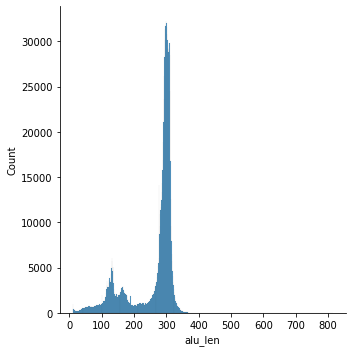

In [20]:
sns.displot(alu_df, x='alu_len', kind='hist')

In [21]:
alu_df = pr.PyRanges(alu_df)

In [22]:
gtf_df = cerberus.add_stable_gid(gtf_df)

In [23]:
gtf_df = gtf_df.loc[gtf_df.Feature == 'gene']

In [29]:
gtf_df.head()
type(gtf_df)

pyranges.pyranges_main.PyRanges

In [30]:
alu_df.head()
type(alu_df)

pyranges.pyranges_main.PyRanges

In [31]:
# intersect gene boundaries w/ alu elements and count up alus / kb
# gtf_df = pr.PyRanges(gtf_df)
temp = gtf_df.join(alu_df,
                   strandedness='same',
                   how='left',
                   report_overlap=True,
                   slack=0)

AssertionError: Can only do stranded operations when both PyRanges contain strand info

In [32]:
pr.__version__

'0.0.127'

In [ ]:
# temp = temp.df

In [ ]:
len(temp.gene_id.unique())

In [92]:
temp['overlaps_alu'] = temp.Overlap==temp.alu_len

In [94]:
# temp.loc[temp.gene_id.duplicated(keep=False)].sort_values(by='gene_id').head()

In [143]:
temp['gene_len'] = (temp.Start-temp.End).abs()
temp2 = temp[['gene_id', 'gene_name', 'gene_len', 'overlaps_alu']].groupby(['gene_id', 'gene_name', 'gene_len']).sum().reset_index().rename({'overlaps_alu': 'n_overlapping_alu'}, axis=1)

In [144]:
# limit just to the orthologs
temp2 = temp2.loc[temp2.gene_id.isin(all_gids)]

In [145]:
temp2['changed_sect'] = temp2.gene_id.isin(gids)

In [146]:
temp2.head()

,gene_id,gene_name,gene_len,n_overlapping_alu,changed_sect
0,ENSG00000000003,TSPAN6,10097,2,False
1,ENSG00000000005,TNMD,15184,1,False
3,ENSG00000000457,SCYL3,44737,7,False
4,ENSG00000000460,C1orf112,59451,12,False
5,ENSG00000000938,FGR,24350,7,False


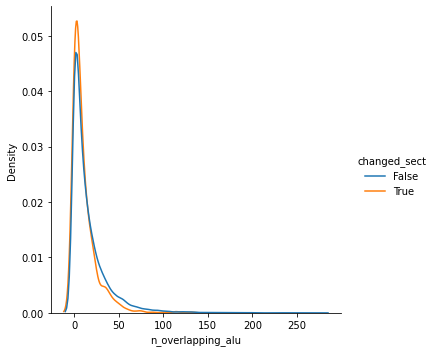

In [147]:
sns.displot(temp2, x='n_overlapping_alu', hue='changed_sect', kind='kde', common_norm=False)

In [148]:
temp2['alus_per_kb'] = ((temp2.n_overlapping_alu)*1000)/temp2.gene_len

In [149]:
temp2.loc[temp2.gene_name=='ELN']

,gene_id,gene_name,gene_len,n_overlapping_alu,changed_sect,alus_per_kb
651,ENSG00000049540,ELN,42219,30,True,0.710581


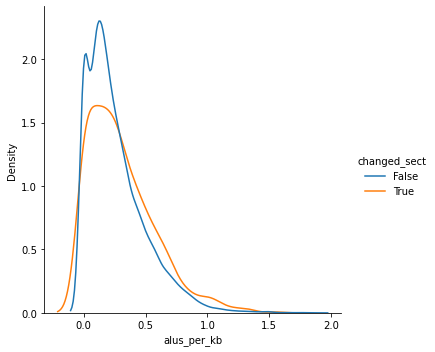

In [150]:
sns.displot(temp2, x='alus_per_kb', hue='changed_sect', kind='kde', common_norm=False)

In [158]:
temp2[['alus_per_kb', 'changed_sect']].groupby('changed_sect').mean()

,alus_per_kb
changed_sect,
False,0.258303
True,0.305462


In [161]:
a = temp2.loc[temp2.changed_sect==True].alus_per_kb.tolist()
b = temp2.loc[temp2.changed_sect==False].alus_per_kb.tolist()
st.kstest(a,b,alternative='two-sided')

KstestResult(statistic=0.09575875217701535, pvalue=1.3477335661030213e-06)

In [160]:
a = temp2.loc[temp2.changed_sect==True].alus_per_kb.tolist()
b = temp2.loc[temp2.changed_sect==False].alus_per_kb.tolist()
st.mannwhitneyu(a,b,alternative='two-sided')

MannwhitneyuResult(statistic=5707665.0, pvalue=5.035784528737582e-06)

In [156]:
a = temp2.loc[temp2.changed_sect==True].alus_per_kb.tolist()
b = temp2.loc[temp2.changed_sect==False].alus_per_kb.tolist()
st.ttest_ind(a,b,alternative='two-sided')

Ttest_indResult(statistic=5.488871060198488, pvalue=4.117915931397596e-08)

In [155]:
# scatter plot of splicing_ratio, n_ic vs. alus_per_kb, also for sectors
source = 'obs_det'
ca = cerberus.read(cerberus_h5)
temp3 = ca.triplets.loc[ca.triplets.source==source]

In [163]:
len(temp3.gid.unique())

26781

In [165]:
temp['gene_len'] = (temp.Start-temp.End).abs()
temp2 = temp[['gene_id', 'gene_name', 'gene_len', 'overlaps_alu']].groupby(['gene_id', 'gene_name', 'gene_len']).sum().reset_index().rename({'overlaps_alu': 'n_overlapping_alu'}, axis=1)
temp2['alus_per_kb'] = ((temp2.n_overlapping_alu)*1000)/temp2.gene_len

In [166]:
temp2.head()

,gene_id,gene_name,gene_len,n_overlapping_alu,alus_per_kb
0,ENSG00000000003,TSPAN6,10097,2,0.198079
1,ENSG00000000005,TNMD,15184,1,0.065859
2,ENSG00000000419,DPM1,25914,11,0.424481
3,ENSG00000000457,SCYL3,44737,7,0.156470
4,ENSG00000000460,C1orf112,59451,12,0.201847


In [167]:
temp3.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,dataset
0,obs_det,ENSG00000000003,1.0,6.0,9.0,28.0,2.571429,0.104478,0.626866,0.268657,tes,TSPAN6,NaN,NaN,NaN
1,obs_det,ENSG00000000005,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,TNMD,NaN,NaN,NaN
2,obs_det,ENSG00000000419,2.0,4.0,9.0,15.0,3.000000,0.222222,0.444444,0.333333,mixed,DPM1,NaN,NaN,NaN
3,obs_det,ENSG00000000457,3.0,4.0,5.0,7.0,1.428571,0.355932,0.474576,0.169492,mixed,SCYL3,NaN,NaN,NaN
4,obs_det,ENSG00000000460,3.0,4.0,7.0,15.0,2.000000,0.333333,0.444444,0.222222,mixed,C1orf112,NaN,NaN,NaN


In [169]:
temp3 = temp3.merge(temp2, how='left', left_on='gid', right_on='gene_id')

In [170]:
temp3.head()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,dataset,gene_id,gene_name,gene_len,n_overlapping_alu,alus_per_kb
0,obs_det,ENSG00000000003,1.0,6.0,9.0,28.0,2.571429,0.104478,0.626866,0.268657,tes,TSPAN6,NaN,NaN,NaN,ENSG00000000003,TSPAN6,10097,2,0.198079
1,obs_det,ENSG00000000005,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,TNMD,NaN,NaN,NaN,ENSG00000000005,TNMD,15184,1,0.065859
2,obs_det,ENSG00000000419,2.0,4.0,9.0,15.0,3.000000,0.222222,0.444444,0.333333,mixed,DPM1,NaN,NaN,NaN,ENSG00000000419,DPM1,25914,11,0.424481
3,obs_det,ENSG00000000457,3.0,4.0,5.0,7.0,1.428571,0.355932,0.474576,0.169492,mixed,SCYL3,NaN,NaN,NaN,ENSG00000000457,SCYL3,44737,7,0.156470
4,obs_det,ENSG00000000460,3.0,4.0,7.0,15.0,2.000000,0.333333,0.444444,0.222222,mixed,C1orf112,NaN,NaN,NaN,ENSG00000000460,C1orf112,59451,12,0.201847


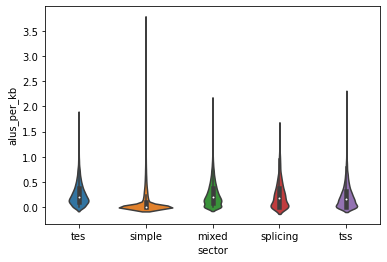

In [171]:
sns.violinplot(temp3, y='alus_per_kb', x='sector')

In [173]:
import itertools
pairs = list(itertools.combinations(temp3.sector.unique().tolist(), 2))
c1 = [c[0] for c in pairs]
c2 = [c[1] for c in pairs]

In [177]:
# t test
for sect1, sect2 in zip(c1, c2):
    v1 = temp3.loc[temp3.sector==sect1, 'alus_per_kb'].tolist()
    v2 = temp3.loc[temp3.sector==sect2, 'alus_per_kb'].tolist()
    result = st.mannwhitneyu(v1, v2, alternative='two-sided')
    p = result.pvalue
    stat = result.statistic
    print(f'{sect1} vs. {sect2}: p={p}, stat={stat}')
    print(f'{sect1} vs. {sect2}: p={p}')
    print()

tes vs. simple: p=0.0, stat=35774637.5
tes vs. simple: p=0.0

tes vs. mixed: p=1.047028679722341e-05, stat=25629294.0
tes vs. mixed: p=1.047028679722341e-05

tes vs. splicing: p=2.2193599272782334e-07, stat=2765059.5
tes vs. splicing: p=2.2193599272782334e-07

tes vs. tss: p=4.047786934715398e-32, stat=7751836.5
tes vs. tss: p=4.047786934715398e-32

simple vs. mixed: p=0.0, stat=19445033.5
simple vs. mixed: p=0.0

simple vs. splicing: p=1.38602370245482e-148, stat=2367053.5
simple vs. splicing: p=1.38602370245482e-148

simple vs. tss: p=4.40552208797187e-309, stat=6264423.0
simple vs. tss: p=4.40552208797187e-309

mixed vs. splicing: p=0.0014051864171778494, stat=4783326.5
mixed vs. splicing: p=0.0014051864171778494

mixed vs. tss: p=6.149086057418628e-19, stat=13348791.0
mixed vs. tss: p=6.149086057418628e-19

splicing vs. tss: p=0.05020394164128465, stat=1272828.0
splicing vs. tss: p=0.05020394164128465

